Please download the file "trainset.csv" and save it into same folder as this notebook.

The two files are the training and test sets created from the California housing dataset.

In [1]:
# setting logging to print only error messages
import logging
logging.basicConfig()
logging.getLogger("SKLEARNEX").setLevel(logging.ERROR)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(palette="Set2")

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
def evaluate_model(model, X, y):
    """Given a model object, predictors and the target, fit and evaluate a model,
    output its RMSE on the training set and on the validation set
    """

    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=7)

    model.fit(X_train, y_train)

    y_train_predict = model.predict(X_train)
    y_val_predict = model.predict(X_val)

    # record the results
    train_rmse = np.sqrt(mean_squared_error(y_train_predict, y_train))
    val_rmse = np.sqrt(mean_squared_error(y_val_predict, y_val))
    
    return train_rmse, val_rmse


def plot_learning_curves(model, X, y):
    
    # create a train-test split
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=7)
    train_errors, val_errors, sizes = [], [], []
    
    # take different sizes of the training data, starting from 50s instance, with the step of 10
    for m in range(50, len(X_train), 10):
        
        # fit a model
        model.fit(X_train[:m], y_train[:m])
        
        # evaluate the model on both training and validation sets
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        
        # calculate RMSE and record the results
        train_rmse = np.sqrt(mean_squared_error(y_train_predict, y_train[:m]))
        val_rmse = np.sqrt(mean_squared_error(y_val_predict, y_val))
        
        train_errors.append(train_rmse)
        val_errors.append(val_rmse)
        sizes.append(m)
        
    # make a plot
    temp_df = pd.DataFrame({"training set size": sizes, 
                        "train": train_errors,
                        "val": val_errors})
    temp_df.plot(x="training set size", y=["train", "val"], kind="line", 
             figsize=(6, 4), ylim=(40000, 80000))

# Load the data

In [3]:
usecols = ["median_income", "INLAND", "population_per_household", "longitude", "latitude", 
           "housing_median_age", "rooms_per_household", "median_house_value"]
trainset = pd.read_csv("trainset.csv", usecols=usecols)

Xtrain = trainset.drop("median_house_value", axis=1)

ytrain = trainset["median_house_value"].copy()

poly_features = PolynomialFeatures(degree=3, include_bias=False)
X_poly = poly_features.fit_transform(Xtrain)

# Ridge Regression

The cost function in Ridge Regression is the sum of squared errors plus a penalty term, which is the sum of squared coefficients:

$\underset{\beta}{\mathrm{argmin}} \sum^{Y}\limits_{i=1} (y_i - \alpha - \sum^{X}\limits_{j=1}\beta_{j} x_{i,j})^2 + \lambda  \sum^{X}\limits_{i=j}\beta_{j}^2$

Plot its learning curve:

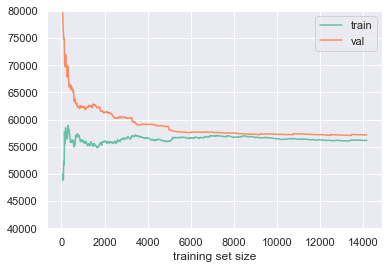

In [4]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler

# first standartize X_poly
scaler = StandardScaler()
X_poly_st = scaler.fit_transform(X_poly)

ridge = Ridge(random_state=7, alpha=50)
plot_learning_curves(ridge, X_poly_st, ytrain)

Train and evaluate a Ridge regression model:

In [5]:
ridge = Ridge(random_state=7, alpha=50)
train_rmse, val_rmse = evaluate_model(ridge, X_poly_st, ytrain)
print(f"Ridge: Train: {train_rmse}, validation: {val_rmse}")

Ridge: Train: 56168.051205293166, validation: 57181.66449746129


# LASSO

The cost function in LASSO Regression is the sum of squared errors plus a penalty term, which is the sum of the absolute values of the coefficients:

$\underset{\beta}{\mathrm{argmin}} \sum^{Y}\limits_{i=1} (y_i - \alpha - \sum^{X}\limits_{j=1}\beta_{j} x_{i,j})^2 + \lambda  \sum^{X}\limits_{i=j}|\beta_{j}|$

In [6]:
from sklearn.linear_model import Lasso

# plotting learning curves takes way too long!
#lasso = Lasso(random_state=7, alpha=1, max_iter=100000)
#plot_learning_curves(lasso, X_poly_st, ytrain)

Train and evaluate a LASSO model:

In [7]:
lasso = Lasso(random_state=7, alpha=0.1, max_iter=1000000)
train_rmse, val_rmse = evaluate_model(lasso, X_poly_st, ytrain)
print(f"Lasso: Train: {train_rmse}, validation: {val_rmse}")

Lasso: Train: 54846.5069032713, validation: 55732.62953776444


Display estimated coefficients on the features. The `coef_` attribute of a `Lasso` object holds the feature coefficients.

In [8]:
lasso.coef_.shape

(119,)

We use the absolute values of the coefficients to determine importance of the features, and then sort them in the descending order (`reverse=True`) to find the most important ones, and in the ascending order (`reverse=False`) to find deleted ones.

In [9]:
abs_scores = np.abs(lasso.coef_)
poly_feature_names = poly_features.get_feature_names_out(input_features=Xtrain.columns)

for score, name in sorted(zip(abs_scores, poly_feature_names), reverse=True):
    print(f"{name}: {score}")

population_per_household^2: 432483.6754074234
latitude population_per_household^2: 292741.6623782751
population_per_household: 251822.101834846
rooms_per_household population_per_household^2: 247839.7309149113
latitude population_per_household: 163230.7992629211
population_per_household^3: 142528.28943733426
median_income population_per_household INLAND: 119820.14167212452
population_per_household INLAND: 118047.64977626466
latitude rooms_per_household population_per_household: 103840.7736954994
latitude median_income population_per_household: 99537.53386138174
housing_median_age population_per_household: 97408.98505569118
rooms_per_household^2 INLAND: 97189.86078259867
median_income population_per_household: 95334.19306862148
longitude latitude population_per_household: 82568.63500381938
latitude median_income: 76896.15757324755
longitude median_income: 73086.91451132299
latitude: 70826.49962565996
longitude rooms_per_household population_per_household: 70197.7572698844
longitude^2 po

# Acknowledgement

The notebook is based on the code examples from [Aurélien Géron's textbook](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) "Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow".


# Citing this notebook

If you use this notebook in your work, please cite it as follows:
    
Pekar, V. (2022). Big Data for Decision Making. Lecture examples and exercises. (Version 1.0.0). URL: https://github.com/vpekar/bd4dm
